<a href="https://colab.research.google.com/github/ravi-gopalan/DAND_Data_Wrangling/blob/master/custom_entity_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [3]:
cd '/gdrive/My Drive/abv_reviews'

/gdrive/My Drive/abv_reviews


In [4]:
!pip install spacymoji
from spacymoji import Emoji

     |████████████████████████████████| 51kB 3.6MB/s 
  Created wheel for emoji: filename=emoji-0.5.4-cp36-none-any.whl size=42175 sha256=61e9544f4d4189e1f39dfd0855cd81d19efd1084160a128072fa5287ef1983ef
  Stored in directory: /root/.cache/pip/wheels/2a/a9/0a/4f8e8cce8074232aba240caca3fade315bb49fac68808d1a9c
Successfully built emoji


In [5]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import re
import random
import srsly
import json
import spacy
from spacy.lang.en import English
from spacy.pipeline import EntityRuler
from spacy import displacy
from spacy.util import minibatch, compounding
from pandas.io.json import json_normalize
from spacy.gold import docs_to_json, biluo_tags_from_offsets, offsets_from_biluo_tags
import spacy.cli
spacy.cli.download("en_core_web_lg")
import en_core_web_lg

import itertools

import matplotlib.pyplot as plt
%matplotlib inline

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [0]:
def cleanse_text(text):
  step1 = re.sub(r"(\{'LOWER':\s)",r"",str(text))
  step2 = re.sub(r"[\[{\'\,\"}\]]",r"",step1)
  return step2

def trim_entity_spans(data: list) -> list:
    """Removes leading and trailing white spaces from entity spans.

    Args:
        data (list): The data to be cleaned in spaCy JSON format.

    Returns:
        list: The cleaned data.
    """
    invalid_span_tokens = re.compile(r'\s')

    cleaned_data = []
    for text, annotations in data:
        entities = annotations['entities']

        print(text, annotations)
        valid_entities = []
        for start, end, label in entities:
          valid_start = start
          valid_end = end
          print(valid_start, valid_end, len(text))
          while valid_start < len(text) and invalid_span_tokens.match(text[valid_start]):
            valid_start += 1
          while valid_end > 1 and invalid_span_tokens.match(text[valid_end - 1]):
            valid_end -= 1
          valid_entities.append([valid_start, valid_end, label])
        cleaned_data.append([text, {'entities': valid_entities}])

    return cleaned_data

def dump_jsonl(data, output_path, append=False):
    """
    Write list of objects to a JSON lines file.
    """
    mode = 'a+' if append else 'w'
    with open(output_path, mode, encoding='utf-8') as f:
        for line in data:
            json_record = json.dumps(line, ensure_ascii=False)
            f.write(json_record + '\n')
    print('Wrote {} records to {}'.format(len(data), output_path))

def load_jsonl(input_path) -> list:
    """
    Read list of objects from a JSON lines file.
    """
    data = []
    with open(input_path, 'r', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line.rstrip('\n|\r')))
    print('Loaded {} records from {}'.format(len(data), input_path))
    return data


def create_entity_pattern(ent_name, ent_label):
  pattern_list = []
  pattern_dict = {}
  id_str = ''
  for word in ent_name.lower().split():
    token_dict = {}
    token_dict['LOWER'] = word
    pattern_list.append(token_dict)
    id_str += '_' + word
  if ent_label[:2] == 'U_':
    pattern_dict['label'] = ent_label[2:]
  else:
    pattern_dict['label'] = ent_label  
  pattern_dict['pattern'] = pattern_list
  if id_str[0] == '_':
    id_str = id_str[1:]
  pattern_dict['id'] = id_str
  return pattern_dict

In [6]:
ls -l patt*

-rw------- 1 root root   2365 Dec 26 18:11 pattern_bread.jsonl
-rw------- 1 root root   4609 Dec 26 18:11 pattern_condiment.jsonl
-rw------- 1 root root   5397 Dec 26 18:11 pattern_fruit.jsonl
-rw------- 1 root root   3946 Dec 26 18:11 pattern_herb.jsonl
-rw------- 1 root root   1700 Dec 26 18:11 pattern_pastry.jsonl
-rw------- 1 root root 529064 Dec 26 14:49 patterns_2019_12_26.jsonl
-rw------- 1 root root 589611 Jan  8 14:35 patterns_2020_01_08.jsonl
-rw------- 1 root root 681304 Jan 12 16:13 patterns.jsonl
-rw------- 1 root root   6749 Dec 26 18:11 pattern_spice.jsonl
-rw------- 1 root root   9140 Dec 26 18:11 pattern_vegetable.jsonl


In [7]:
df_pattern = pd.read_json('patterns.jsonl',lines=True)
df_pattern['cleaned_pattern'] = df_pattern.pattern.apply(lambda x: cleanse_text(x))
df_pattern['label'] = 'U_' + df_pattern.label.astype(str)
df_pattern['tup_col'] = list(zip(df_pattern.cleaned_pattern, df_pattern.label))
df_pattern['merged'] = df_pattern.apply(lambda row: {row['cleaned_pattern']:row['label']}, axis=1)
df_pattern.head()
df_pattern.tail()

,label,pattern,id,cleaned_pattern,tup_col,merged
7682,U_vegetable,"[{'LOWER': 'wing'}, {'LOWER': 'bean'}]",wing_bean,wing bean,"(wing bean, U_vegetable)",{'wing bean': 'U_vegetable'}
7683,U_vegetable,"[{'LOWER': 'yellow'}, {'LOWER': 'pepper'}]",yellow_pepper,yellow pepper,"(yellow pepper, U_vegetable)",{'yellow pepper': 'U_vegetable'}
7684,U_vegetable,"[{'LOWER': 'yellow'}, {'LOWER': 'zucchini'}]",yellow_zucchini,yellow zucchini,"(yellow zucchini, U_vegetable)",{'yellow zucchini': 'U_vegetable'}
7685,U_vegetable,[{'LOWER': 'zucchini'}],zucchini,zucchini,"(zucchini, U_vegetable)",{'zucchini': 'U_vegetable'}
7686,U_vegetable,[{'LOWER': 'zucchinis'}],zucchinis,zucchinis,"(zucchinis, U_vegetable)",{'zucchinis': 'U_vegetable'}


In [0]:
x = df_pattern[['id','label']].groupby(['id'],as_index=False).count().sort_values(by=['label'],ascending=False)
check = list(x.query('label > 1')['id'])
df_pattern.query('id in @check').sort_values(by=['cleaned_pattern','label'],ascending=False).to_csv('tbc.csv')

In [8]:
ent_list = df_pattern.tup_col.to_list()
ent_list[-10:]

[('veggie', 'U_vegetable'),
 ('veggies', 'U_vegetable'),
 ('water chestnut', 'U_vegetable'),
 ('watercress', 'U_vegetable'),
 ('white radish', 'U_vegetable'),
 ('wing bean', 'U_vegetable'),
 ('yellow pepper', 'U_vegetable'),
 ('yellow zucchini', 'U_vegetable'),
 ('zucchini', 'U_vegetable'),
 ('zucchinis', 'U_vegetable')]

In [0]:
nlp = spacy.load("en_core_web_lg")
ruler = EntityRuler(nlp).from_disk("patterns.jsonl")
emoji = Emoji(nlp)
nlp.add_pipe(emoji, first=True)
nlp.add_pipe(ruler, before='ner')
merge_ents = nlp.create_pipe("merge_entities")
nlp.add_pipe(merge_ents, after='ner')

In [10]:
nlp.pipe_names

['emoji', 'tagger', 'parser', 'entity_ruler', 'ner', 'merge_entities']

In [0]:
ruler = EntityRuler(nlp).from_disk("patterns.jsonl")

In [11]:
ruler.patterns[-3:]

[{'id': 'yellow_pepper',
  'label': 'vegetable',
  'pattern': [{'LOWER': 'yellow'}, {'LOWER': 'pepper'}]},
 {'id': 'yellow_zucchini',
  'label': 'vegetable',
  'pattern': [{'LOWER': 'yellow'}, {'LOWER': 'zucchini'}]},
 {'id': 'zucchini', 'label': 'vegetable', 'pattern': [{'LOWER': 'zucchini'}]}]

In [12]:
doc1 = nlp("I love fettuccine feta camembert cheese 💚🌿 but hate buffalo wings while one of my favorite cuisines is Lebanese diet alongwith almond milk and matcha")
print([(ent.text, ent.label_, ent.ent_id_) for ent in doc1.ents])

displacy.render(doc1,'ent',jupyter=True)

[('fettuccine', 'dish', 'fettuccine'), ('feta', 'dish', 'feta'), ('cheese', 'dish', 'cheese'), ('buffalo wings', 'dish', 'buffalo_wings'), ('Lebanese', 'NORP', 'lebanese'), ('almond milk', 'beverage', 'almond_milk'), ('matcha', 'beverage', 'matcha')]


In [13]:
doc2 = nlp("Avocado 🌿 is good but Indian cuising such as chicken tikka masala and paneer tikka masala are fantastic while sweet potato fries is atrocious in Egypt and India")
displacy.render(doc2,'ent',jupyter=True)

In [0]:
doc3 = nlp("Firstly, baguette is the best bread in the whole world - bagels came close last year and for ten dollars ciabatta from Italy is available")
displacy.render(doc3,'ent',jupyter=True)

In [0]:
doc4 = nlp("Peanut butter ice cream is good this week, but chocolate ice cream is better.")
displacy.render(doc4,'ent',jupyter=True)

In [14]:
doc5 = nlp("basil is a great herb and the first ice cream I tasted was good but shitake mushroom stem and baby corn at $5 is yet to be seen. #crfsg")
displacy.render(doc5,'ent',jupyter=True)

In [11]:
reviews = pd.read_csv('reviews_text.csv',usecols=['_id', 'text'])
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56156 entries, 0 to 56155
Data columns (total 2 columns):
_id     56156 non-null object
text    56155 non-null object
dtypes: object(2)
memory usage: 877.6+ KB


In [12]:
reviews.head()

,_id,text
0,59e599911747c90004ba8586,Burger joint offers a wide range of cheeseburg...
1,59ff122b8b04fd0004df6c78,It was really good. The mushroom broth was esp...
2,5dc251e552e7e90020b6adfb,"$8.90 for sesame rice, mushroom rendang, curry..."
3,5d35cf4049745d0004c68de3,2 mains + 1 green rice bento from greendot. Re...
4,5d304e9264f5e5000423b75b,The lion mane mushroom rendang is so delicious...


In [13]:
reviews.dropna(inplace=True)
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56155 entries, 0 to 56155
Data columns (total 2 columns):
_id     56155 non-null object
text    56155 non-null object
dtypes: object(2)
memory usage: 1.3+ MB


In [0]:
train_reviews = reviews['text'][:1000]
eval_reviews = reviews['text'][1000:2000]
test_reviews = reviews['text'][2000:3000]


In [14]:
print(train_reviews.shape[0], eval_reviews.shape[0], test_reviews.shape[0])

1000 1000 1000


In [0]:
ingredients_list = ['pistachio', 'almond', 'walnut', 'cashew', 'peanuts', 'macadamia', 'hazelnuts', 'pecan', 'brazil nut', 'pine nut' ]
issues_list = ['crumble - maybe a verb', 'milk']
food_times = 
to_be_added_list = ['spirulina', 'spinach','eggs', 'nut butters', 'aubergines',  'tomato',\
                    'oysters', 'kale', 'cucumber', 'quinoa', 'tomatoes', 'onion' ,'garlic', 'avocado', 'chilli', 'dark chocolate', 'mushrooms', 'coriander' ,'corn chips',\
                    'marinara', 'donuts', 'olives', 'crackers', 'waffles', 'blueberry', 'raspberry', 'compote', 'mayo', 'mayonnaise', 'soy milk', \
                    'caffeine', 'milk tea', 'cauliflower', 'sorbet', 'banana', 'goji berry', 'chickpea', 'spinach', 'romaine',\
                    'pear', 'artichoke', 'mango', 'sandwich', 'capsicum', 'wedge',\
                     'olive oil']

In [0]:
check = np.random.randint(0,50000,3)
print(check)

for doc in list(nlp.pipe(texts[check])):
  displacy.render(doc,'ent',jupyter=True)
#  displacy.render(doc,'dep',jupyter=True,options={'distance': 60, 'fine_grained': True})



[49671 32259 46827]


In [0]:
f = open('rice.txt')
docs = [] # initialize a list to be populated wih strings
lines = f.readlines()  # returns a list of srings from the txt file
for line in lines:
    # print(line[:]) # display the sentence from that line
    doc = nlp(line) # convert string into a spacy doc object using nlp
    docs.append(doc) # add new doc to the list of docs

json_data = docs_to_json(docs) # convert doc into a json file
srsly.write_json('spacy_train.json', [json_data])


In [0]:
f.close()

In [0]:
check_list = [('bok','U_vegetable'),('choy','U_vegetable'),\
              ('bean','U_vegetable'), ('sprouts','U_vegetable'),\
              ('soffritto','U_dish'),('patties','U_dish'),('cakes','U_dish'),('parmesan','U_dish'),('cheese','U_dish'),('breadcrumbs','U_dish'),\
              ('soy','U_condiment'),('sauce','U_condiment'),\
              ('olive','U_condiment'),('oil','U_condiment'),\
              ('wine','U_beverage'),\
              ('3/4-inch','U_QUANTITY'), ('2-inch','U_QUANTITY'),('3-inch','U_QUANTITY'),('6-inch','U_QUANTITY'),\
              ('first','U_ORDINAL'),('second','U_ORDINAL'),('third','U_ORDINAL'),('fourth','U_ORDINAL'),('fifth','U_ORDINAL'),('last','U_ORDINAL'),\
              
              ('minute','U_TIME'),('minutes','U_TIME'),('seconds','U_TIME'),('hour','U_TIME'),('hours','U_TIME'),('day','U_TIME'),\
              ('$', 'U_MONEY'), ('USD', 'U_MONEY'),('SGD', 'U_MONEY'),('S$', 'U_MONEY'), ('Rs', 'U_MONEY'), ('£', 'U_MONEY'), ('€', 'U_MONEY')]

In [0]:
f = open('rice.txt')
docs = [] # initialize a list to be populated wih strings
lines = f.readlines()  # returns a list of srings from the txt file
for line in lines:
    # print(line[:]) # display the sentence from that line
    doc = nlp(line) # convert string into a spacy doc object using nlp
    docs.append(doc) # add new doc to the list of docs
f.close()



In [0]:
train_gen = (rev for rev in train_reviews)
type(train_gen)
to_train_ents = []
check_list = []

In [20]:
len(list(train_reviews))

1000

In [0]:
for raw, doc in zip(list(train_reviews), nlp.pipe(list(train_reviews))):
  tok_list = [token.text for token in doc]
  tag_list = ['O' for token in doc]
  matched_ents = [(i,item) for i, item in enumerate(tok_list) if item.lower() in [i[0] for i in ent_list + check_list]]

  for ent in matched_ents:
    ent_tag = ''.join(list(set([tup[1] for tup in ent_list + check_list if tup[0] == ent[1].lower()])))
    #print(ent[0], ent[1], ent_tag)
    tag_list[ent[0]] = ent_tag
  #print(tag_list)
  entities = offsets_from_biluo_tags(doc, tag_list)
  #print(entities)
  to_train_ents.append((raw, dict(entities = entities)))
  #print(raw)
  #displacy.render(doc,'ent',jupyter=True)
  #print(entities)

In [17]:
clean_train_ents = trim_entity_spans(to_train_ents)

Burger joint offers a wide range of cheeseburger choices and vegetarian mushroom option. Price range from $12 for the standard cheeseburger to the top of the range double jalapeno bacon cheeseburger at $30.40.

We ordered the vegetarian option which is the Portobello mushroom burger with the option to add jalapeno. Inside the bun it comes with tomato, onions, pickles and lettuce, basically what you expect from a burger. Currently burger joint is only offering the Portobello mushroom burger as their only choice of vegetarian option but I spoke to Darius, the manager who said that they will be sampling more vegetarian options in the coming weeks. I asked why they are bringing in more vegetarian options is because there is a increase demand for vegetarian dishes. 

Waiting time for the he Portobello burger was about 10 minutes and it came In a paper bag and it was well wrapped inside. When you unwrap the burger, you can just imagine how huge the burger is and it can barely fit into your m

In [18]:
dump_jsonl(clean_train_ents,'train.jsonl')

Wrote 1000 records to train.jsonl


In [0]:
l = next(train_gen)
tok_list = [token.text for token in nlp(l)] 
#print(l, tok_list)
tag_list = ['O' for token in nlp(l)]
#print(tag_list)
matched_ents = [(i,item) for i, item in enumerate(tok_list) if item.lower() in [i[0] for i in ent_list + check_list]] 
#print(matched_ents)

for ent in matched_ents:
  ent_tag = ''.join(list(set([tup[1] for tup in ent_list + check_list if tup[0] == ent[1].lower()])))
  print(ent[0], ent[1], ent_tag)
  tag_list[ent[0]] = ent_tag

#print(tag_list)
entities = offsets_from_biluo_tags(nlp(l), tag_list)
print(entities)
to_train_ents.append((l, dict(entities = entities)))
displacy.render(nlp(l),'ent',jupyter=True)
print(l, entities)

#displacy.render(l,'dep',jupyter=True)

[]


Leave alone for five to seven minutes, then serve. []


In [23]:
len(to_train_ents)
#to_train_ents[-5:]

1000

In [0]:
to_train_ents[0:5]

[('If using tofu, cook it.\n', {'entities': [(9, 13, 'dish')]}),
 ('Cook the rice as you normally would, but be careful not to use too much water. The rice should not be too sticky. It may help to let the cooked rice sit overnight in the refrigerator.\n',
  {'entities': [(9, 13, 'dish'), (83, 87, 'dish'), (137, 148, 'dish')]}),
 ('If using onions, dice them into whatever size you prefer.\n',
  {'entities': [(9, 15, 'vegetable')]}),
 ('If using bok choy, separate the stalk part from the leaf part. Slice the leaf part crosswise into 3/4-inch-thick strips, then tear the strips into 2-inch pieces. These pieces will be treated much like the bean sprouts, though perhaps with slightly more cooking. The stalk part will be treated as celery.\n',
  {'entities': [(9, 17, 'vegetable'),
    (98, 106, 'QUANTITY'),
    (147, 153, 'QUANTITY'),
    (205, 217, 'vegetable'),
    (296, 302, 'vegetable')]}),
 ('If using bean sprouts, wash them and discard any that are not white and crunchy.\n',
  {'entitie

In [0]:
dump_jsonl()

In [0]:

merged = list(itertools.chain(*[tup[1]['entities'] for tup in to_train_ents]))

In [0]:
model = 'en_core_web_lg'



"""Load the model, set up the pipeline and train the entity recognizer."""
if model is not None:
    nlp = spacy.load(model)  # load existing spaCy model
    print("Loaded model '%s'" % model)
else:
    nlp = spacy.blank("en")  # create blank Language class
    print("Created blank 'en' model")

# nlp.create_pipe works for built-ins that are registered with spaCy
if "ner" not in nlp.pipe_names:
    ner = nlp.create_pipe("ner")
    nlp.add_pipe(ner, last=True)
# otherwise, get it so we can add labels
else:
    ner = nlp.get_pipe("ner")

# add labels
for _, annotations in to_train_ents:
    for ent in annotations.get("entities"):
        ner.add_label(ent[2])

Loaded model 'en_core_web_lg'


In [0]:
ner.labels

('dish',
 'ORG',
 'condiment',
 'FAC',
 'vegetable',
 'ORDINAL',
 'PERSON',
 'PRODUCT',
 'LOC',
 'spice',
 'CARDINAL',
 'LANGUAGE',
 'TIME',
 'WORK_OF_ART',
 'GPE',
 'DATE',
 'LAW',
 'NORP',
 'beverage',
 'MONEY',
 'EVENT',
 'herb',
 'PERCENT',
 'QUANTITY')

In [0]:
check_list = []

In [0]:

to_train_ents = []

In [20]:
train_rev = (rev for rev in train_reviews)
type(train_rev)

generator

In [160]:
rev = next(train_rev)
tok_list = [token.text for token in nlp(rev)] 
tag_list = ['O' for token in nlp(rev)]
matched_ents = [(i,item) for i, item in enumerate(tok_list) if item.lower() in [i[0] for i in ent_list + check_list]] 
#print(rev, tok_list, tag_list, matched_ents)

ent_for_doc = []
pattern_dict = {}
for ent in matched_ents:
  ent_tag = ''.join(list(set([tup[1] for tup in ent_list + check_list if tup[0] == ent[1].lower()])))
  ent_for_doc.append((ent[0], ent[1], ent_tag))  
  tag_list[ent[0]] = ent_tag
print(ent_for_doc)
#print(tag_list)
entities = offsets_from_biluo_tags(nlp(rev), tag_list)
print(entities)
to_train_ents.append((rev, dict(entities = entities)))
displacy.render(nlp(rev),'ent',jupyter=True)
print(rev)


n_entities_to_be_added = int(input("How many entities are missing: "))
if n_entities_to_be_added == 0:
  print('You entered {} Thanks. So no new entities to be considered'.format(n_entities_to_be_added))
else:
  for user_input in range(n_entities_to_be_added):
    e_name = input('Provide the name of the entity to be added: ')
    e_label = input('Provide the label of the entity to be added:')
    print(e_name, e_label)
    check_list.append((e_name, e_label))
    pattern_list = []

    pattern_dict = create_entity_pattern(e_name, e_label)
    dump_jsonl([pattern_dict],'patterns.jsonl', append=True)
    ruler = EntityRuler(nlp).from_disk("patterns.jsonl")

[(10, 'avocado', 'U_fruit'), (17, 'lime', 'U_fruit')]
[(58, 65, 'fruit'), (83, 87, 'fruit')]


Super original and definitely worth trying if you’re into avocado. A bit more of a lime zing would go a long way to making this amazing.
How many entities are missing: 0
You entered 0 Thanks. So no new entities to be considered


In [1]:
len(to_train_ents)

NameError: ignored

In [0]:
[(ent.text, ent.label_, ent.ent_id_) for ent in nlp("Its raining bok choy and jalapeno for € 3 in Singapore").ents]

[('bok choy', 'vegetable', 'bok_choy'),
 ('jalapeno', 'vegetable', 'jalapeno'),
 ('Singapore', 'GPE', 'singapore')]

In [0]:
check_list

In [162]:
check_list

[('chilli oil', 'U_condiment'),
 ('micro - greens', 'U_vegetable'),
 ('cacao', 'U_condiment'),
 ('spirulina', 'U_vegetable'),
 ('gojiberries', 'U_fruit'),
 ('dimsum', 'U_dish'),
 ('chilli sauce', 'U_condiment'),
 ('dimsums', 'U_dish'),
 ('1 inch', 'QUANTITY'),
 ('2 inch', 'QUANTITY'),
 ('3 inch', 'QUANTITY'),
 ('old chengdu', 'ORG'),
 ('wok hei', 'U_dish'),
 ('chinatownsg', 'LOC'),
 ('animalplace', 'ORG'),
 ('100 gms', 'QUANTITY'),
 ('50 gms', 'QUANTITY'),
 ('2 bowls', 'QUANTITY'),
 ('vinegar', 'U_condiment'),
 ('beyond burger', 'PRODUCT'),
 ("bill 's pizza", 'ORG'),
 ('daiya vegan cheese', 'U_dish'),
 ('chilli peppers', 'U_condiment'),
 ('pure vegan', 'ORG'),
 ('micro greens', 'U_vegetable'),
 ('cheung chau island', 'LOC'),
 ('coconut cream', 'U_condiment'),
 ('vegan cheeses', 'U_dish'),
 ('veggie spinner', 'ORG'),
 ('chilli sauce', 'U_condiment'),
 ('plant - based', 'U_lifestyle'),
 ('buddhist', 'NORP'),
 ('4', 'CARDINAL'),
 ('$ 238HKD', 'MONEY'),
 ('$ 25hkd', 'MONEY'),
 ('red bean s

In [0]:
ruler = EntityRuler(nlp).from_disk("patterns.jsonl")

In [0]:
check_list[-5:]

[('brussels sprouts', 'U_vegetable'),
 ('soy sesame', 'U_condiment'),
 ('soya sesame', 'U_condiment'),
 ('squash', 'U_vegetable'),
 ('honey mustard sauce', 'U_condiment')]

In [0]:
len(to_train_ents)

51

In [19]:
#model = 'en_core_web_lg'
model = None


"""Load the model, set up the pipeline and train the entity recognizer."""
if model is not None:
    nlp = spacy.load(model)  # load existing spaCy model
    print("Loaded model '%s'" % model)
else:
    nlp = spacy.blank("en")  # create blank Language class
    print("Created blank 'en' model")

# nlp.create_pipe works for built-ins that are registered with spaCy
if "ner" not in nlp.pipe_names:
    ner = nlp.create_pipe("ner")
    nlp.add_pipe(ner, last=True)
# otherwise, get it so we can add labels
else:
    ner = nlp.get_pipe("ner")

# add labels
for _, annotations in to_train_ents:
    for ent in annotations.get("entities"):
        ner.add_label(ent[2])

Created blank 'en' model


In [20]:
ner.labels

('EVENT',
 'LOC',
 'NORP',
 'PERSON',
 'seed',
 'CARDINAL',
 'DATE',
 'dish',
 'product',
 'bread',
 'ORDINAL',
 'TIME',
 'PRODUCT',
 'meal',
 'ORG',
 'FAC',
 'GPE',
 'herb',
 'fruit',
 'vegetable',
 'food_habit',
 'beverage',
 'MONEY',
 'spice',
 'pastry',
 'sandwich',
 'lifestyle',
 'condiment',
 'QUANTITY',
 'vegetableU_spice')

In [0]:
len(to_train_ents)

200

In [26]:
clean_train_ents = trim_entity_spans(to_train_ents)

Burger joint offers a wide range of cheeseburger choices and vegetarian mushroom option. Price range from $12 for the standard cheeseburger to the top of the range double jalapeno bacon cheeseburger at $30.40.

We ordered the vegetarian option which is the Portobello mushroom burger with the option to add jalapeno. Inside the bun it comes with tomato, onions, pickles and lettuce, basically what you expect from a burger. Currently burger joint is only offering the Portobello mushroom burger as their only choice of vegetarian option but I spoke to Darius, the manager who said that they will be sampling more vegetarian options in the coming weeks. I asked why they are bringing in more vegetarian options is because there is a increase demand for vegetarian dishes. 

Waiting time for the he Portobello burger was about 10 minutes and it came In a paper bag and it was well wrapped inside. When you unwrap the burger, you can just imagine how huge the burger is and it can barely fit into your m

In [0]:
# get names of other pipes to disable them during training
#other_pipes = [pipe for pipe in nlp.pipe_names if pipe not in ["ner", "entity_ruler","merge_entities"]]

other_pipes = [pipe for pipe in nlp.pipe_names if pipe not in ["ner"]]

loss_trend = []
with nlp.disable_pipes(*other_pipes):  # only train NER
    # reset and initialize the weights randomly – but only if we're
    # training a new model
    if model is None:
        nlp.begin_training()



    for itn in range(200):
      random.shuffle(clean_train_ents)
      losses = {}

#      for item in clean_train_ents:
# batch up the examples using spaCy's minibatch
      batches = minibatch(clean_train_ents, size=compounding(4.0, 32.0, 1.001))

      for batch in batches:
        texts, annotations = zip(*batch)
#        print([item[0]], [item[1]])

#        print(texts)
#        print(annotations)
        nlp.update(texts, annotations, drop=0.5, losses=losses)
        loss_trend.append(losses['ner'])

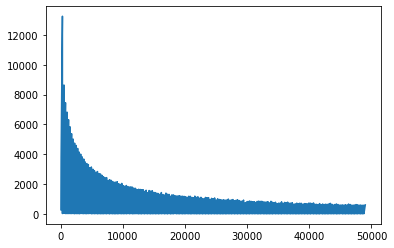

In [23]:
plt.plot(loss_trend)

In [1]:
nlp.pipe_names


NameError: ignored

In [0]:
ruler = EntityRuler(nlp).from_disk("patterns.jsonl")
nlp.add_pipe(ruler, before='ner')
merge_ents = nlp.create_pipe("merge_entities")
nlp.add_pipe(merge_ents, after='ner')
nlp.pipe_names

['tagger', 'parser', 'entity_ruler', 'ner', 'merge_entities']

In [33]:
#test_docs = reviews['text'][51500:51510]

for doc in test_docs:
  displacy.render(nlp(doc),'ent',jupyter=True)
  print([(ent.text, ent.label_) for ent in nlp(doc).ents])

[]


[]


[('drops', 'vegetable'), ('Blue Latte', 'ORG'), ('hot latte', 'beverage'), ('coconut', 'fruit'), ('maple syrup', 'dish'), ('latte', 'beverage'), ('bostonvegan', 'lifestyle')]


[('Si', 'ORG')]


[('Sadie Mae', 'ORG'), ('gluten free', 'food_habit'), ('vegan', 'lifestyle'), ('vanilla', 'spice'), ('vanilla', 'spice')]


[]


[('Deliciosa', 'dish'), ('saludable', 'dish')]


[('las', 'dish'), ('otras', 'dish')]


[('Quisiera', 'spice'), ('dar', 'dish')]


[('pareció', 'vegetable'), ('plato', 'vegetable'), ('buen', 'dish'), ('Recomendado', 'LOC')]


In [0]:
pwd

'/gdrive/My Drive/abv_reviews'

In [0]:
check_list

[('bok', 'U_vegetable'),
 ('choy', 'U_vegetable'),
 ('bean', 'U_vegetable'),
 ('sprouts', 'U_vegetable'),
 ('soffritto', 'U_dish'),
 ('patties', 'U_dish'),
 ('cakes', 'U_dish'),
 ('parmesan', 'U_dish'),
 ('cheese', 'U_dish'),
 ('breadcrumbs', 'U_dish'),
 ('soy', 'U_condiment'),
 ('sauce', 'U_condiment'),
 ('olive', 'U_condiment'),
 ('oil', 'U_condiment'),
 ('wine', 'U_beverage'),
 ('3/4-inch', 'U_QUANTITY'),
 ('2-inch', 'U_QUANTITY'),
 ('3-inch', 'U_QUANTITY'),
 ('6-inch', 'U_QUANTITY'),
 ('first', 'U_ORDINAL'),
 ('second', 'U_ORDINAL'),
 ('third', 'U_ORDINAL'),
 ('fourth', 'U_ORDINAL'),
 ('fifth', 'U_ORDINAL'),
 ('last', 'U_ORDINAL'),
 ('1', 'U_CARDINAL'),
 ('2', 'U_CARDINAL'),
 ('3', 'U_CARDINAL'),
 ('4', 'U_CARDINAL'),
 ('5', 'U_CARDINAL'),
 ('6', 'U_CARDINAL'),
 ('10', 'U_CARDINAL'),
 ('100', 'U_CARDINAL'),
 ('one', 'U_CARDINAL'),
 ('two', 'U_CARDINAL'),
 ('three', 'U_CARDINAL'),
 ('four', 'U_CARDINAL'),
 ('five', 'U_CARDINAL'),
 ('six', 'U_CARDINAL'),
 ('seven', 'U_CARDINAL'),
 ('

In [0]:
nlp.to_disk('trained_model_2020_01_12')

In [1]:
by 

NameError: ignored

In [36]:
type(clean_train_ents)

list

In [0]:
import json

with open('checklist.txt', 'w') as f:
    f.write(json.dumps(check_list))

In [0]:
[token.pos_ for token in nlp("lion's mane mushroom falafels")]

['NOUN', 'PART', 'NOUN', 'NOUN', 'NOUN']

In [0]:
for doc in list(nlp.pipe(texts[check])):
  displacy.render(doc,'ent',jupyter=True)
#  displacy.render(doc,'dep',jupyter=True,options={'distance': 60, 'fine_grained': True})